In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1. DENOISING

In [4]:
# Install YOLOv8 and dependencies
!pip install ultralytics roboflow

In [5]:
import ultralytics
ultralytics.checks()


Ultralytics 8.3.114 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 6281.8/8062.4 GB disk)


In [6]:
from roboflow import Roboflow

rf = Roboflow(api_key="DNOeHhkRNeZC22OYkD6l")  # Replace with your Roboflow API key
project = rf.workspace("railway-project").project("railway-track-uqhmu")
dataset = project.version(10).download("yolov8")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to railway-track-10 in yolov8:: 100%|██████████| 1554/1554 [00:01<00:00, 1154.97it/s]


In [7]:
pip install opencv-python


Note: you may need to restart the kernel to use updated packages.


In [8]:
import cv2
import os

# Input and output folder paths
input_folder = "/kaggle/working/railway-track-10/train/images"
output_folder = input_folder + "_denoised"

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Denoising using Gaussian Blur
def denoise_dataset(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, filename)
            image = cv2.imread(img_path)

            if image is None:
                print(f" Could not read {filename}. Skipping.")
                continue

            # Apply Gaussian blur for denoising
            denoised = cv2.GaussianBlur(image, (5, 5), 0)

            # Save the denoised image
            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, denoised)

# Run denoising
denoise_dataset(input_folder, output_folder)
print(f" Denoising complete. Denoised images saved to: {output_folder}")


 Denoising complete. Denoised images saved to: /kaggle/working/railway-track-10/train/images_denoised


2. NORMALIZATION

In [9]:
import cv2
import os
import numpy as np


input_folder = "/kaggle/working/railway-track-10/train/images_denoised"
output_folder = input_folder + "_normalized"


os.makedirs(output_folder, exist_ok=True)


def normalize_dataset(input_folder, output_folder):
    for filename in os.listdir(input_folder):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(input_folder, filename)
            image = cv2.imread(img_path).astype(np.float32)

            if image is None:
                print(f" Failed to load: {filename}")
                continue

            
            normalized = image / 255.0

            
            output_image = (normalized * 255).astype(np.uint8)

            output_path = os.path.join(output_folder, filename)
            cv2.imwrite(output_path, output_image)


normalize_dataset(input_folder, output_folder)
print(f" Normalization complete. Normalized images saved to: {output_folder}")


 Normalization complete. Normalized images saved to: /kaggle/working/railway-track-10/train/images_denoised_normalized


3. AUGMENTATION

In [10]:
!pip install albumentations --quiet


this albumentations is imported because while augmentation, labels will change thier coordinates. so this library augments the labels alongwith the images.

In [11]:
import albumentations as A
import cv2
import os
import numpy as np

# === PATHS ===
image_dir = "/kaggle/working/railway-track-10/train/images_denoised_normalized"
label_dir = "/kaggle/working/railway-track-10/train/labels"
output_image_dir = image_dir + "_augmented"
output_label_dir = label_dir + "_augmented"

# === AUGMENTATION PIPELINE ===
def clip_bboxes(bboxes):
    """
    Clip bounding boxes to ensure they are within the range [0, 1]
    """
    return [
        [
            min(max(bbox[0], 0.0), 1.0),  # x_min
            min(max(bbox[1], 0.0), 1.0),  # y_min
            min(max(bbox[2], 0.0), 1.0),  # x_max
            min(max(bbox[3], 0.0), 1.0)   # y_max
        ]
        for bbox in bboxes
    ]

# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3)
], bbox_params=A.BboxParams(
    format='yolo',
    label_fields=['class_labels'],
    min_visibility=0.2,
    check_each_transform=True
))

# === CREATE OUTPUT FOLDERS ===
os.makedirs(output_image_dir, exist_ok=True)
os.makedirs(output_label_dir, exist_ok=True)

# === AUGMENTATION LOOP ===
for filename in os.listdir(image_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(image_dir, filename)
        label_path = os.path.join(label_dir, filename.replace('.jpg', '.txt'))

        # Load image
        image = cv2.imread(image_path)
        if image is None:
            print(f"❌ Skipping unreadable image: {filename}")
            continue

        # Load labels
        bboxes = []
        class_labels = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if len(parts) < 5:
                        print(f"❌ Invalid label format in {filename}, skipping.")
                        continue  # Skip invalid labels
                    class_labels.append(int(parts[0]))  # Assuming class starts from 0
                    bbox = list(map(float, parts[1:]))
                    bboxes.append(bbox)

        if not bboxes:
            print(f"❌ No bounding boxes for {filename}, skipping.")
            continue  # Skip if no valid bbox

        # Debugging output before converting to numpy
        print(f"Before augmentation, image: {filename}, bboxes: {bboxes}")

        # Convert bboxes to numpy array for Albumentations
        try:
            bboxes = np.array(bboxes)
        except ValueError as e:
            print(f"❌ Error converting bboxes for {filename}: {e}")
            continue

        # Clip bounding boxes to be within [0, 1]
        bboxes = clip_bboxes(bboxes)

        # Debugging output after clipping bounding boxes
        print(f"After clipping, bboxes: {bboxes}")

        # Apply transformation
        try:
            transformed = transform(image=image, bboxes=bboxes, class_labels=class_labels)
        except ValueError as e:
            print(f"❌ Error during transformation of {filename}: {e}")
            continue

        # Debugging output for augmented bounding boxes
        print(f"After augmentation, image: {filename}, bboxes: {transformed['bboxes']}")

        # Save augmented image
        aug_image = transformed['image']
        cv2.imwrite(os.path.join(output_image_dir, filename), aug_image)

        # Save updated labels
        with open(os.path.join(output_label_dir, filename.replace('.jpg', '.txt')), 'w') as f:
            for cls, bbox in zip(transformed['class_labels'], transformed['bboxes']):
                f.write(f"{cls} {' '.join(map(str, bbox))}\n")

print(f"✅ Augmentation complete!\n🖼️ Images saved to: {output_image_dir}\n📝 Labels saved to: {output_label_dir}")


A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


Before augmentation, image: Image-896_jpg.rf.f06730371f96968538e41a49e74274ed.jpg, bboxes: [[0.5025000000000001, 0.5139285714285714, 0.9950446428571428, 0.4252232142857143]]
After clipping, bboxes: [[0.5025000000000001, 0.5139285714285714, 0.9950446428571428, 0.4252232142857143]]
❌ Error during transformation of Image-896_jpg.rf.f06730371f96968538e41a49e74274ed.jpg: Expected x_max for bbox [  0.0049777     0.30132           1     0.72654           3] to be in the range [0.0, 1.0], got 1.000022292137146.
Before augmentation, image: photo_2023-10-04_11-32-12_jpg.rf.4b8b37c3ff9bdef8246a1360ec2812ee.jpg, bboxes: [[0.3451212121212121, 0.50446875, 0.48821212121212126, 0.24591406249999997]]
After clipping, bboxes: [[0.3451212121212121, 0.50446875, 0.48821212121212126, 0.24591406249999997]]
After augmentation, image: photo_2023-10-04_11-32-12_jpg.rf.4b8b37c3ff9bdef8246a1360ec2812ee.jpg, bboxes: [[0.6550446631707298, 0.4974895441497575, 0.5279318308920948, 0.26692413172016194]]
Before augmentat

NOW SPLIT THE DATASET IN TRAIN,TEST,VALIDATION ACCORDING TO YOLOV8 FORMAT

In [12]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Define paths for augmented dataset
base_path = '/kaggle/working/railway-track-10/train'
image_dir = os.path.join(base_path, 'images_denoised_normalized_augmented')
label_dir = os.path.join(base_path, 'labels_augmented')

# Get a list of all image files
image_files = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'jpeg', 'png'))]

# Split dataset into train, validation, and test sets (80% train, 10% val, 10% test)
train_images, test_images = train_test_split(image_files, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Create YOLO directory structure with 'train1', 'val1', 'test1'
yolo_base_dir = '/kaggle/working/railway-track-10/yolov8_dataset'
os.makedirs(os.path.join(yolo_base_dir, 'images', 'train1'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_dir, 'images', 'val1'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_dir, 'images', 'test1'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_dir, 'labels', 'train1'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_dir, 'labels', 'val1'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_dir, 'labels', 'test1'), exist_ok=True)

# Move images and labels to YOLO directory structure
def move_files_to_yolo_format(files, src_image_dir, src_label_dir, dest_image_dir, dest_label_dir):
    for file in files:
        # Move images
        image_path = os.path.join(src_image_dir, file)
        dest_image_path = os.path.join(dest_image_dir, file)
        shutil.copy(image_path, dest_image_path)

        # Move label files
        label_file = file.replace('.jpg', '.txt').replace('.jpeg', '.txt').replace('.png', '.txt')
        label_path = os.path.join(src_label_dir, label_file)
        dest_label_path = os.path.join(dest_label_dir, label_file)
        shutil.copy(label_path, dest_label_path)

# Move train, validation, and test images/labels to 'train1', 'val1', 'test1'
move_files_to_yolo_format(train_images, image_dir, label_dir, os.path.join(yolo_base_dir, 'images', 'train1'), os.path.join(yolo_base_dir, 'labels', 'train1'))
move_files_to_yolo_format(val_images, image_dir, label_dir, os.path.join(yolo_base_dir, 'images', 'val1'), os.path.join(yolo_base_dir, 'labels', 'val1'))
move_files_to_yolo_format(test_images, image_dir, label_dir, os.path.join(yolo_base_dir, 'images', 'test1'), os.path.join(yolo_base_dir, 'labels', 'test1'))

# Create the YAML config file
yaml_file = '/kaggle/working/railway-track-10/yolov8_dataset.yaml'
yaml_content = """
train: /kaggle/working/railway-track-10/yolov8_dataset/images/train1
val: /kaggle/working/railway-track-10/yolov8_dataset/images/val1
test: /kaggle/working/railway-track-10/yolov8_dataset/images/test1

nc: 1  # number of classes
names: ['normal']  # class names
"""
with open(yaml_file, 'w') as file:
    file.write(yaml_content)

print("Dataset is now prepared for YOLOv8 with the new folder names.")


Dataset is now prepared for YOLOv8 with the new folder names.


In [13]:
pip install ultralytics


Note: you may need to restart the kernel to use updated packages.


In [32]:
from ultralytics import YOLO

# Load the YOLOv8s model
model = YOLO('yolov8s.pt')  # Pre-trained YOLOv8s weights

# Specify the path to your dataset configuration file (yaml file)
dataset_yaml = '/kaggle/working/railway-track-10/yolov8_dataset.yaml'

# Check if the YAML is correct (optional)
with open(dataset_yaml, 'r') as file:
    print(file.read())

# Fine-tuning the model
model.train(
    data=dataset_yaml,    # Path to the dataset YAML file
    epochs=80,            # Number of training epochs
    batch=16,             # Batch size
    imgsz=640,            # Image size
    save=True,            # Save the best weights
    cache=True            # Cache dataset for faster training
)

# After training, the best weights will be saved automatically



train: /kaggle/working/railway-track-10/yolov8_dataset/images/train1
val: /kaggle/working/railway-track-10/yolov8_dataset/images/val1
test: /kaggle/working/railway-track-10/yolov8_dataset/images/test1

nc: 1  # number of classes
names: ['normal']  # class names

New https://pypi.org/project/ultralytics/8.3.115 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.114 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/kaggle/working/railway-track-10/yolov8_dataset.yaml, epochs=80, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, drop

train: Scanning /kaggle/working/railway-track-10/yolov8_dataset/labels/train1... 456 images, 0 backgrounds, 399 corrupt: 100%|██████████| 456/456 [00:00<00:00, 1879.13it/s]

train: /kaggle/working/railway-track-10/yolov8_dataset/images/train1/131051004_382613492830631_1306891331783850055_n_jpg.rf.738a5e5a3ac826ac812f383684f91898.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /kaggle/working/railway-track-10/yolov8_dataset/images/train1/131084537_190751489449739_279862595635733772_n_jpg.rf.2387131eda27984e532a98b121bc1e5c.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /kaggle/working/railway-track-10/yolov8_dataset/images/train1/131129946_140815574232570_8925999503657494497_n_jpg.rf.9e1fd820c7acfa44a36c68dc0956037b.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /kaggle/working/railway-track-10/yolov8_dataset/images/train1/131275810_2686956714949012_5021348409242545922_n_jpg.rf.ef1b2f6f4c586d910459c9d48332bb01.jpg: ignoring corrupt image/label: Label c

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.1GB RAM): 100%|██████████| 57/57 [00:00<00:00, 64.82it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 673.2±811.3 MB/s, size: 1577.6 KB)


val: Scanning /kaggle/working/railway-track-10/yolov8_dataset/labels/val1.cache... 153 images, 0 backgrounds, 131 corrupt: 100%|██████████| 153/153 [00:00<?, ?it/s]

val: /kaggle/working/railway-track-10/yolov8_dataset/images/val1/131065180_999185033824671_7735147288489715620_n_jpg.rf.d132298cd77e0f920739bf4b9add6500.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /kaggle/working/railway-track-10/yolov8_dataset/images/val1/1727787781841_jpg.rf.b5e7ed8e6895b722a8e5766e4ba742ee.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 1. Possible class labels are 0-0
val: /kaggle/working/railway-track-10/yolov8_dataset/images/val1/1727787782252_jpg.rf.fffc33584eba9277b646d8ec28d9ebcd.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 1. Possible class labels are 0-0
val: /kaggle/working/railway-track-10/yolov8_dataset/images/val1/1727787878849_jpg.rf.a27af90b9343978895f89e60bb5e794f.jpg: ignoring corrupt image/label: Label class 3 exceeds dataset class count 1. Possible class labels are 0-0
val: /kaggle/working/railway-track-10/yolov8_datas

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.0GB RAM): 100%|██████████| 22/22 [00:00<00:00, 51.59it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train2
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      8.93G      3.325      11.57      2.854         32        640: 100%|██████████| 4/4 [00:01<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]


                   all         22         34   0.000303     0.0588   0.000165    4.1e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      5.21G      3.402      10.08      2.832         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.73it/s]

                   all         22         34   0.000455     0.0882   0.000251   6.64e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      5.22G      3.217      7.486      2.716         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         22         34       0.11     0.0588     0.0265    0.00651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      5.22G      2.702      4.667      2.383         15        640: 100%|██████████| 4/4 [00:01<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.25it/s]

                   all         22         34    0.00565      0.147    0.00353    0.00102



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      5.22G       2.29      3.256       2.15         20        640: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]


                   all         22         34      0.493      0.441      0.322     0.0928

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      5.24G       2.25      2.856      2.029         20        640: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]


                   all         22         34     0.0951      0.353     0.0502     0.0116

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      5.24G      2.156      2.421      1.929         21        640: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


                   all         22         34      0.186      0.235      0.132     0.0507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      5.24G      2.138      2.355      1.932         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]


                   all         22         34      0.325      0.618        0.3     0.0785

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      5.24G      2.298      2.404      2.059         21        640: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


                   all         22         34      0.167      0.235      0.105     0.0326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      5.24G      2.197      2.441      1.965         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


                   all         22         34      0.439      0.382      0.288     0.0815

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      5.24G        2.2      2.563      1.885         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all         22         34      0.072      0.265      0.033     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      5.24G      2.052      2.196      1.789         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


                   all         22         34       0.33      0.235      0.238     0.0937

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80      5.24G      2.035      1.987      1.862         15        640: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         22         34       0.52      0.294      0.331     0.0891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      5.24G      2.058      1.828      1.962         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         22         34      0.311      0.235      0.194     0.0513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      5.24G      2.056      1.774      1.857         18        640: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         22         34      0.801     0.0588     0.0811     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      5.24G       2.07      1.842      1.946         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


                   all         22         34     0.0826      0.471     0.0606     0.0186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      5.24G      2.123       1.88      1.922         20        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


                   all         22         34      0.028      0.559     0.0227    0.00661

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      5.24G      2.134      1.712      1.885         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         22         34      0.367      0.441      0.342      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      5.24G      1.989      1.808      1.951         22        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


                   all         22         34      0.348      0.382      0.281     0.0798

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      5.24G      2.025      1.796      1.912         26        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


                   all         22         34      0.442      0.326      0.303     0.0768

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      5.24G      1.987      1.772      1.834         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]

                   all         22         34      0.444      0.324       0.33     0.0961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      5.24G      2.035      1.728      2.016         21        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         22         34      0.494      0.373      0.295     0.0739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80      5.24G      1.833      1.823      1.838         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         22         34      0.768      0.412      0.489      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      5.24G      1.908      1.735      1.971         13        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         22         34      0.822      0.441      0.522      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      5.24G      1.955       1.72      1.834         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         22         34      0.537      0.294      0.272     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      5.24G      2.144      1.467      2.003         32        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         22         34      0.849     0.0588     0.0587     0.0256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      5.24G          2      1.905      1.829         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         22         34      0.156      0.176     0.0958      0.027



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      5.24G      1.944      1.518      1.792         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         22         34      0.278      0.382      0.257     0.0804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      5.24G      1.847      1.795      1.854         22        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.50it/s]

                   all         22         34      0.457      0.421      0.346     0.0899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      5.24G      1.974      1.673      1.965         22        640: 100%|██████████| 4/4 [00:01<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         22         34      0.573      0.412      0.351     0.0814



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      5.24G      1.731      1.512      1.815         21        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         22         34      0.561      0.471       0.39     0.0941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      5.24G      1.861      1.351      1.747         17        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         22         34      0.576      0.441      0.379      0.105



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      5.24G      1.801      1.324       1.77         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]


                   all         22         34      0.722      0.688      0.618      0.139

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      5.24G      1.948      1.362      1.836         34        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.56it/s]

                   all         22         34      0.838      0.647      0.609      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      5.24G      1.838      1.276      1.798         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         22         34      0.748      0.559      0.542      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      5.24G      1.786      1.322      1.773         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         22         34      0.547      0.496      0.362     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80      5.24G      1.709      1.168      1.659         15        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         22         34      0.435      0.382       0.32     0.0861



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      5.24G      1.874      1.191      1.741         22        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         22         34      0.251      0.412      0.166     0.0431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      5.24G      1.637      1.135      1.609         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         22         34      0.634       0.51      0.527      0.145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      5.24G      1.764      1.322      1.747         21        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         22         34      0.888      0.466      0.593      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      5.24G       1.84      1.361      1.795         16        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         22         34      0.734      0.382      0.447      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      5.24G      1.706      1.161      1.595         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.57it/s]

                   all         22         34      0.629      0.399      0.412      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      5.24G      1.796      1.149      1.712         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         22         34       0.78      0.522      0.554      0.129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      5.24G      1.737      1.154      1.704         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         22         34       0.62        0.5      0.495      0.114



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      5.24G      1.671      1.249      1.674         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         22         34      0.515      0.529      0.435      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      5.24G      1.636      1.125      1.649         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         22         34      0.577      0.559      0.436     0.0971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      5.24G       1.71      1.109      1.719         16        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         22         34      0.606      0.589      0.452      0.116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      5.24G      1.658       1.12      1.689         19        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         22         34      0.465      0.471       0.42      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      5.24G      1.567      1.047      1.585         33        640: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         22         34      0.623      0.438       0.44      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80      5.24G      1.643      1.052      1.653         24        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.49it/s]

                   all         22         34        0.8      0.353      0.429     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      5.24G      1.646      1.074      1.614         20        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         22         34      0.517      0.441      0.431      0.109



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      5.24G      1.609      1.112      1.633         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]

                   all         22         34      0.648      0.441      0.464      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      5.24G      1.807        1.2       1.85         18        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


                   all         22         34      0.655      0.441      0.459     0.0991

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      5.24G      1.631      1.083      1.661         18        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         22         34      0.545      0.441      0.352     0.0889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      5.24G      1.385     0.9661      1.542         20        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         22         34       0.51      0.529      0.406     0.0929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      5.24G      1.471      1.043      1.588         16        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         22         34      0.597      0.529      0.477      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      5.24G      1.621      1.059      1.736         19        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         22         34      0.672      0.529       0.48      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      5.24G      1.537     0.9907      1.587         31        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         22         34      0.741      0.471      0.498      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      5.24G      1.451     0.9613      1.552         21        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         22         34      0.627        0.5      0.432      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      5.24G      1.403     0.9208      1.499         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         22         34      0.667      0.559      0.532      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/80      5.24G       1.51     0.9305       1.56         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         22         34       0.64      0.559      0.492      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/80      5.24G      1.502     0.9601      1.505         32        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         22         34      0.623      0.559      0.488      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/80      5.24G      1.393     0.8679      1.515         25        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         22         34      0.633      0.559      0.498      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/80      5.24G      1.337     0.8905      1.474         18        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         22         34      0.615      0.529      0.438      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/80      5.24G      1.282     0.8958      1.399         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         22         34       0.69      0.529      0.507       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/80      5.24G      1.325     0.8506      1.431         30        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         22         34      0.689      0.521      0.523      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/80      5.24G      1.313     0.8874      1.401         27        640: 100%|██████████| 4/4 [00:01<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

                   all         22         34      0.665      0.529      0.521      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/80      5.24G      1.297     0.9645      1.469         29        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         22         34       0.69      0.529      0.515       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/80      5.24G      1.306     0.8955      1.466         23        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         22         34       0.67      0.471       0.47      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/80      5.24G      1.297     0.8218      1.431         28        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.60it/s]

                   all         22         34      0.714      0.529      0.554       0.13


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/80      5.24G      1.258     0.9003      1.538         11        640: 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.35it/s]


                   all         22         34      0.712      0.529      0.569      0.141

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/80      5.24G      1.201     0.7574      1.478         15        640: 100%|██████████| 4/4 [00:01<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]

                   all         22         34      0.695      0.559      0.572      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/80      5.24G      1.254     0.8097      1.524         16        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         22         34      0.731      0.638      0.622      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/80      5.24G      1.221     0.8068       1.47         12        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.23it/s]

                   all         22         34      0.798      0.618      0.659      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/80      5.24G      1.189      0.746      1.429         13        640: 100%|██████████| 4/4 [00:01<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         22         34      0.835      0.647      0.683      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      76/80      5.24G      1.228     0.7614      1.471         16        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         22         34      0.826      0.647      0.666      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      77/80      5.24G      1.204     0.7612      1.479         12        640: 100%|██████████| 4/4 [00:01<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.64it/s]

                   all         22         34      0.829      0.647      0.664      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      78/80      5.24G      1.147     0.7455      1.418          8        640: 100%|██████████| 4/4 [00:01<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         22         34      0.824      0.647      0.663      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      79/80      5.24G      1.081     0.6791      1.369         11        640: 100%|██████████| 4/4 [00:01<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         22         34      0.811      0.647      0.655      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      80/80      5.24G      1.146     0.7212       1.38         15        640: 100%|██████████| 4/4 [00:01<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.63it/s]

                   all         22         34      0.803      0.647      0.661       0.18



80 epochs completed in 0.038 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.114 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.10it/s]


                   all         22         34      0.803      0.647      0.661       0.18


invalid value encountered in less
invalid value encountered in less


Speed: 0.2ms preprocess, 5.1ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e779e89c7d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [15]:
# import yaml

# # Path to your YAML file
# yaml_path = '/kaggle/working/railway-track-10/yolov8_dataset.yaml'

# # Load and print the YAML contents
# with open(yaml_path, 'r') as file:
#     config = yaml.safe_load(file)

# print(config)


In [16]:
# import os
# import glob

# # Remove cache files that might be outdated
# cache_files = glob.glob("/kaggle/working/railway-track-10/yolov8_dataset/**/train1.cache", recursive=True)
# for file in cache_files:
#     os.remove(file)
#     print(f"Removed: {file}")


In [17]:
# import yaml

# data_yaml = {
#     'path': '/kaggle/working/railway-track-10/yolov8_dataset',
#     'train': 'images/train1',
#     'val': 'images/val1',
#     'test': 'images/test1',
#     'nc': 4,
#     'names': ['normal', 'bolt_missing', 'crack', 'clip_missing']
# }

# with open('/kaggle/working/railway-track-10/yolov8_dataset.yaml', 'w') as f:
#     yaml.dump(data_yaml, f)


In [44]:
import os

cache_path = '/kaggle/working/railway-track-10/yolov8_dataset/labels/train1.cache'
if os.path.exists(cache_path):
    os.remove(cache_path)
    print("Old val cache removed.")


Old val cache removed.


In [19]:
# with open('/kaggle/working/railway-track-10/yolov8_dataset.yaml') as f:
#     print(f.read())


NOW CONVERT THE DATASET DIRECTORY INTO THE ONE REQUIRED BY FAST RCNN STRUCTURE AND THEN TRAIN ON IT.

In [46]:
import os
import shutil
import json
from PIL import Image

# Define dataset paths
existing_train_images = '/kaggle/working/railway-track-10/yolov8_dataset/images/train1'
existing_train_annotations = '/kaggle/working/railway-track-10/yolov8_dataset/labels/train1'
existing_val_images = '/kaggle/working/railway-track-10/yolov8_dataset/images/val1'
existing_val_annotations = '/kaggle/working/railway-track-10/yolov8_dataset/labels/val1'

# Define new directory for Faster R-CNN
fast_rcnn_dir = 'fast_rcnn'
train_dir = os.path.join(fast_rcnn_dir, 'train')
val_dir = os.path.join(fast_rcnn_dir, 'val')

# Create necessary folders
os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'annotations'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'annotations'), exist_ok=True)

# Category names
categories = ["normal", "bolt_missing", "crack", "clip_missing"]

# Copy images from source to destination
def copy_images(src_dir, dest_dir):
    for image_name in os.listdir(src_dir):
        if image_name.endswith('.jpg'):
            shutil.copy(os.path.join(src_dir, image_name), os.path.join(dest_dir, image_name))

# Convert YOLO annotations to COCO format
def convert_annotations(src_annotation_dir, dest_annotation_dir, image_dir, category_mapping):
    images = []
    annotations = []
    image_id = 1
    annotation_id = 1

    for image_name in os.listdir(image_dir):
        if not image_name.endswith('.jpg'):
            continue

        image_path = os.path.join(image_dir, image_name)
        image = Image.open(image_path)
        width, height = image.size

        annotation_path = os.path.join(src_annotation_dir, image_name.replace(".jpg", ".txt"))
        valid_annotations = []

        if os.path.exists(annotation_path):
            with open(annotation_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    try:
                        class_id = int(float(parts[0]))
                        xmin, ymin, xmax, ymax = map(float, parts[1:])

                        if xmax <= xmin or ymax <= ymin:
                            continue

                        bbox = [xmin, ymin, xmax - xmin, ymax - ymin]
                        annotation_info = {
                            "id": annotation_id,
                            "image_id": image_id,
                            "category_id": category_mapping[class_id],
                            "bbox": bbox,
                            "area": bbox[2] * bbox[3],
                            "iscrowd": 0
                        }
                        valid_annotations.append(annotation_info)
                    except Exception as e:
                        print(f"Skipping bad line in {image_name}: {line} -- {e}")
                        continue

        if len(valid_annotations) > 0:
            image_info = {
                "id": image_id,
                "width": width,
                "height": height,
                "file_name": image_name
            }
            images.append(image_info)
            annotations.extend(valid_annotations)
            annotation_id += len(valid_annotations)
            image_id += 1

    return images, annotations

# Save COCO format annotations to JSON
def create_coco_json(images, annotations, output_file, categories):
    coco_json = {
        "images": images,
        "annotations": annotations,
        "categories": [{"id": i + 1, "name": category, "supercategory": "none"} for i, category in enumerate(categories)]
    }
    with open(output_file, 'w') as json_file:
        json.dump(coco_json, json_file)

# Start processing
copy_images(existing_train_images, os.path.join(train_dir, 'images'))
copy_images(existing_val_images, os.path.join(val_dir, 'images'))

train_images, train_annotations = convert_annotations(
    existing_train_annotations,
    os.path.join(train_dir, 'annotations'),
    os.path.join(train_dir, 'images'),
    category_mapping={0: 1, 1: 2, 2: 3, 3: 4}
)

val_images, val_annotations = convert_annotations(
    existing_val_annotations,
    os.path.join(val_dir, 'annotations'),
    os.path.join(val_dir, 'images'),
    category_mapping={0: 1, 1: 2, 2: 3, 3: 4}
)

create_coco_json(train_images, train_annotations, os.path.join(train_dir, 'annotations', 'train_annotations.json'), categories)
create_coco_json(val_images, val_annotations, os.path.join(val_dir, 'annotations', 'val_annotations.json'), categories)

print("✅ Dataset has been successfully copied and converted to COCO format.")


✅ Dataset has been successfully copied and converted to COCO format.


In [21]:
pip install torch torchvision pycocotools


Note: you may need to restart the kernel to use updated packages.


In [47]:
import os
import json
from torchvision import datasets, transforms
from torch.utils.data import Dataset
from PIL import Image
from pycocotools.coco import COCO

class CustomDataset(Dataset):
    def __init__(self, root, annotation_file, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation_file)
        self.ids = list(self.coco.imgs.keys())

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.root, img_info['file_name'])
        image = Image.open(path).convert("RGB")

        # Get annotations for the image
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)

        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])  # Format [xmin, ymin, xmax, ymax]
            labels.append(ann['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.ids)


In [48]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader

# Load dataset
train_dataset = CustomDataset(
    root=os.path.join('fast_rcnn', 'train', 'images'),
    annotation_file=os.path.join('fast_rcnn', 'train', 'annotations', 'train_annotations.json'),
    transforms=transforms.ToTensor()
)

val_dataset = CustomDataset(
    root=os.path.join('fast_rcnn', 'val', 'images'),
    annotation_file=os.path.join('fast_rcnn', 'val', 'annotations', 'val_annotations.json'),
    transforms=transforms.ToTensor()
)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Load pre-trained Faster R-CNN model
model = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the model to match the number of classes in your dataset
num_classes = 5  # 4 classes + 1 for background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

roi_align_backward_kernel does not have a deterministic implementation, but you set 'torch.use_deterministic_algorithms(True, warn_only=True)'. You can file an issue at https://github.com/pytorch/pytorch/issues to help us prioritize adding deterministic support for this operation. (Triggered internally at ../aten/src/ATen/Context.cpp:91.)


Epoch 1/7, Loss: 0.6392, Time: 84.53s
Epoch 2/7, Loss: 0.3018, Time: 84.49s
Epoch 3/7, Loss: 0.2181, Time: 84.38s
Epoch 4/7, Loss: 0.1707, Time: 83.99s
Epoch 5/7, Loss: 0.1461, Time: 84.49s
Epoch 6/7, Loss: 0.1439, Time: 84.47s
Epoch 7/7, Loss: 0.1378, Time: 84.51s


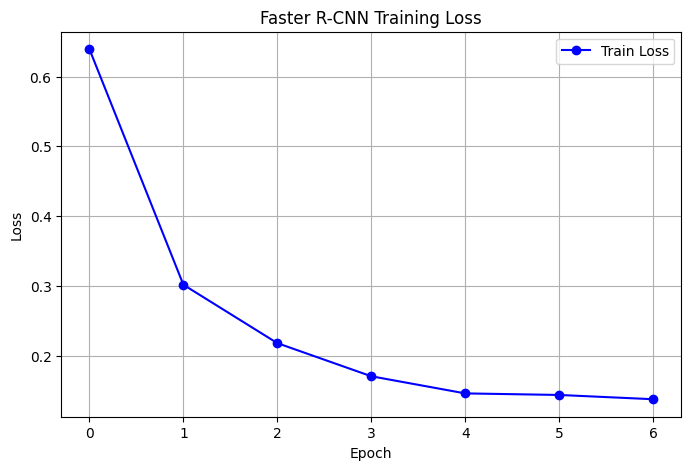

In [49]:
import time
import torch
import matplotlib.pyplot as plt

# Optimizer and learning rate scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Track loss values
train_losses = []

# Training loop
num_epochs = 7
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()

    for images, targets in train_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        loss_dict = model(images, targets)

        # Total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        losses.backward()
        optimizer.step()

        running_loss += losses.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Print epoch statistics
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Time: {epoch_time:.2f}s")

# Save the trained model
torch.save(model.state_dict(), 'faster_rcnn.pth')

# Plot the training loss
plt.figure(figsize=(8, 5))
plt.plot(train_losses, marker='o', linestyle='-', color='blue', label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Faster R-CNN Training Loss')
plt.grid(True)
plt.legend()
plt.savefig('fastrcnn_loss_curve.png')  # Save the plot
plt.show()


In [34]:
class CustomDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_names = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        while True:
            image_name = self.image_names[idx]
            image_path = os.path.join(self.image_dir, image_name)
            annotation_path = os.path.join(self.annotation_dir, image_name.replace('.jpg', '.txt'))

            if not os.path.exists(annotation_path):
                # Skip this image if annotation file is missing
                idx = (idx + 1) % len(self.image_names)
                continue  # Go to the next index

            image = Image.open(image_path)
            with open(annotation_path, 'r') as file:
                annotations = file.readlines()

            boxes = []
            labels = []
            for annotation in annotations:
                parts = annotation.strip().split()
                class_id = int(parts[0])
                xmin, ymin, xmax, ymax = map(float, parts[1:])
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(class_id)

            # Convert to tensors
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)

            target = {'boxes': boxes, 'labels': labels}

            if self.transform:
                image = self.transform(image)

            return image, target


In [35]:
from torch.utils.data import DataLoader

# Define any transformations needed for your images (e.g., resizing, normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the validation dataset and DataLoader
val_dataset = CustomDataset(
    image_dir=os.path.join(val_dir, 'images'),
    annotation_dir=os.path.join(val_dir, 'annotations'),
    transform=transform
)

val_data_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))


In [43]:
model.eval()  # Set the model to evaluation mode
val_loss = 0
with torch.no_grad():  # No need to compute gradients during evaluation
    for images, targets in val_data_loader:  # Assuming you have a validation DataLoader
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # Forward pass
        loss_dict = model(images, targets)
        val_loss += sum(loss for loss in loss_dict.values())

print(f"Validation loss: {val_loss / len(val_data_loader)}")


KeyboardInterrupt: 

# ENSEMBLE LEARNING
**NOW COMBINING THE RESUTS OF YOLOV8 AND FASTER RCNN**

In [ ]:
# all_boxes = yolo_boxes + fastrcnn_boxes
# all_scores = yolo_scores + fastrcnn_scores
# all_labels = yolo_labels + fastrcnn_labels

# # Then apply NMS (PyTorch or custom)
# keep = torchvision.ops.nms(torch.tensor(all_boxes), torch.tensor(all_scores), iou_threshold=0.5)

# final_boxes = [all_boxes[i] for i in keep]
# final_scores = [all_scores[i] for i in keep]
# final_labels = [all_labels[i] for i in keep]


In [ ]:
# import torch
# from torchvision.ops import nms

# # YOLOv8 Inference
# from ultralytics import YOLO
# yolo_model = YOLO('runs/detect/train/weights/best.pt')
# yolo_result = yolo_model('/kaggle/working/runs/detect/train6/results.png')[0]

# yolo_boxes = yolo_result.boxes.xyxy.cpu()
# yolo_scores = yolo_result.boxes.conf.cpu()
# yolo_labels = yolo_result.boxes.cls.cpu().int()



# # Combine
# all_boxes = torch.cat((yolo_boxes, fastrcnn_boxes), dim=0)
# all_scores = torch.cat((yolo_scores, fastrcnn_scores), dim=0)
# all_labels = torch.cat((yolo_labels, fastrcnn_labels), dim=0)

# # Apply NMS
# keep = nms(all_boxes, all_scores, iou_threshold=0.5)

# final_boxes = all_boxes[keep]
# final_scores = all_scores[keep]
# final_labels = all_labels[keep]

# # Visualize or save results
# print("Boxes:", final_boxes)
# print("Scores:", final_scores)
# print("Labels:", final_labels)


In [ ]:
# model.eval()
# image_tensor = transform(image).to(device).unsqueeze(0)  # Make sure image is a batch

# with torch.no_grad():
#     outputs = model(image_tensor)

# fastrcnn_boxes = outputs[0]['boxes'].cpu().numpy().tolist()
# fastrcnn_scores = outputs[0]['scores'].cpu().numpy().tolist()
# fastrcnn_labels = outputs[0]['labels'].cpu().numpy().tolist()


In [ ]:
# import torch
# from torchvision.ops import nms

# # Convert YOLO lists to tensors if needed
# yolo_boxes = torch.tensor(yolo_result.boxes.xyxy.cpu().numpy())
# yolo_scores = torch.tensor(yolo_result.boxes.conf.cpu().numpy())
# yolo_labels = torch.tensor(yolo_result.boxes.cls.cpu().numpy()).int()

# # Already tensors for Faster R-CNN, just ensure .cpu()
# fastrcnn_boxes = outputs[0]['boxes'].cpu()
# fastrcnn_scores = outputs[0]['scores'].cpu()
# fastrcnn_labels = outputs[0]['labels'].cpu()
# # Combine both model outputs
# all_boxes = torch.cat((yolo_boxes, fastrcnn_boxes), dim=0)
# all_scores = torch.cat((yolo_scores, fastrcnn_scores), dim=0)
# all_labels = torch.cat((yolo_labels, fastrcnn_labels), dim=0)

# # Apply Non-Maximum Suppression
# keep = nms(all_boxes, all_scores, iou_threshold=0.5)

# # Final predictions
# final_boxes = all_boxes[keep]
# final_scores = all_scores[keep]
# final_labels = all_labels[keep]

# print("Boxes:", final_boxes)
# print("Scores:", final_scores)
# print("Labels:", final_labels)


In [ ]:
# import cv2
# import matplotlib.pyplot as plt
# import random

# # Load the original image
# image_path = "/kaggle/working/fast_rcnn/train/images/131065180_999185033824671_7735147288489715620_n_jpg.rf.d132298cd77e0f920739bf4b9add6500.jpg"  # change this to your image
# image = cv2.imread(image_path)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Define label names if available (update as per your dataset)
# class_names = ['bolt missing', 'crack', 'clip missing', 'normal track', 'fault']

# # Draw the boxes
# for box, score, label in zip(final_boxes, final_scores, final_labels):
#     x1, y1, x2, y2 = map(int, box.tolist())
#     color = [random.randint(0, 255) for _ in range(3)]
#     cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
#     label_text = f"{class_names[label]}: {score:.2f}"
#     cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# # Show the image
# plt.figure(figsize=(12, 8))
# plt.imshow(image)
# plt.axis('off')
# plt.title("Final Combined Predictions (YOLO + Faster R-CNN)")
# plt.show()


**CONFUSION MATRIX OF YOLOv8**

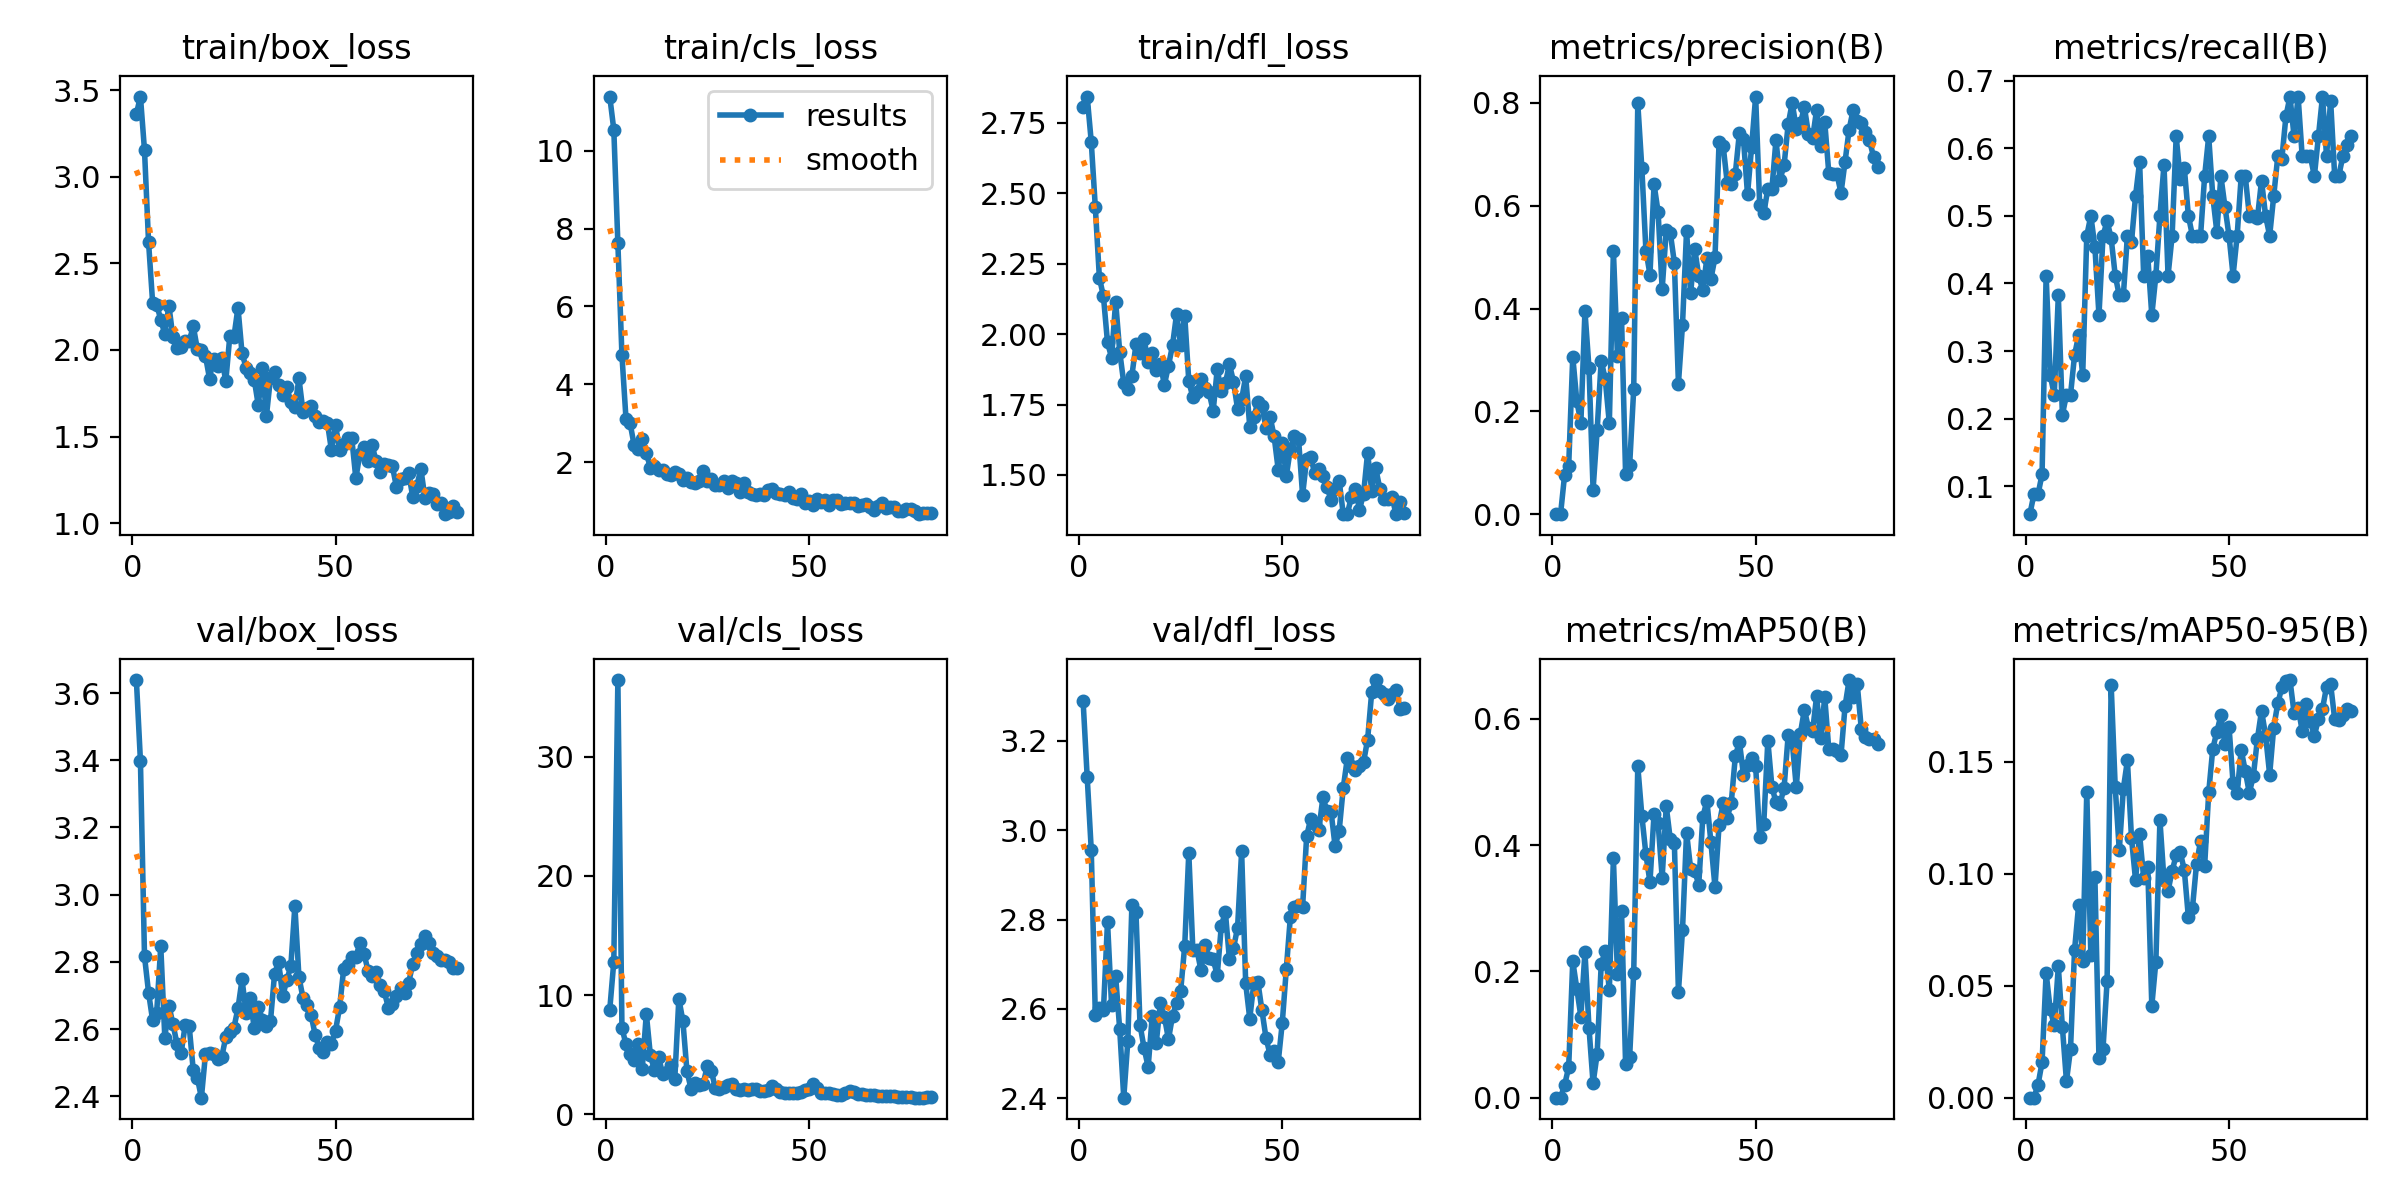

In [40]:
from IPython.display import Image

# Display the image from the saved path
Image(filename='/kaggle/working/runs/detect/train/results.png')


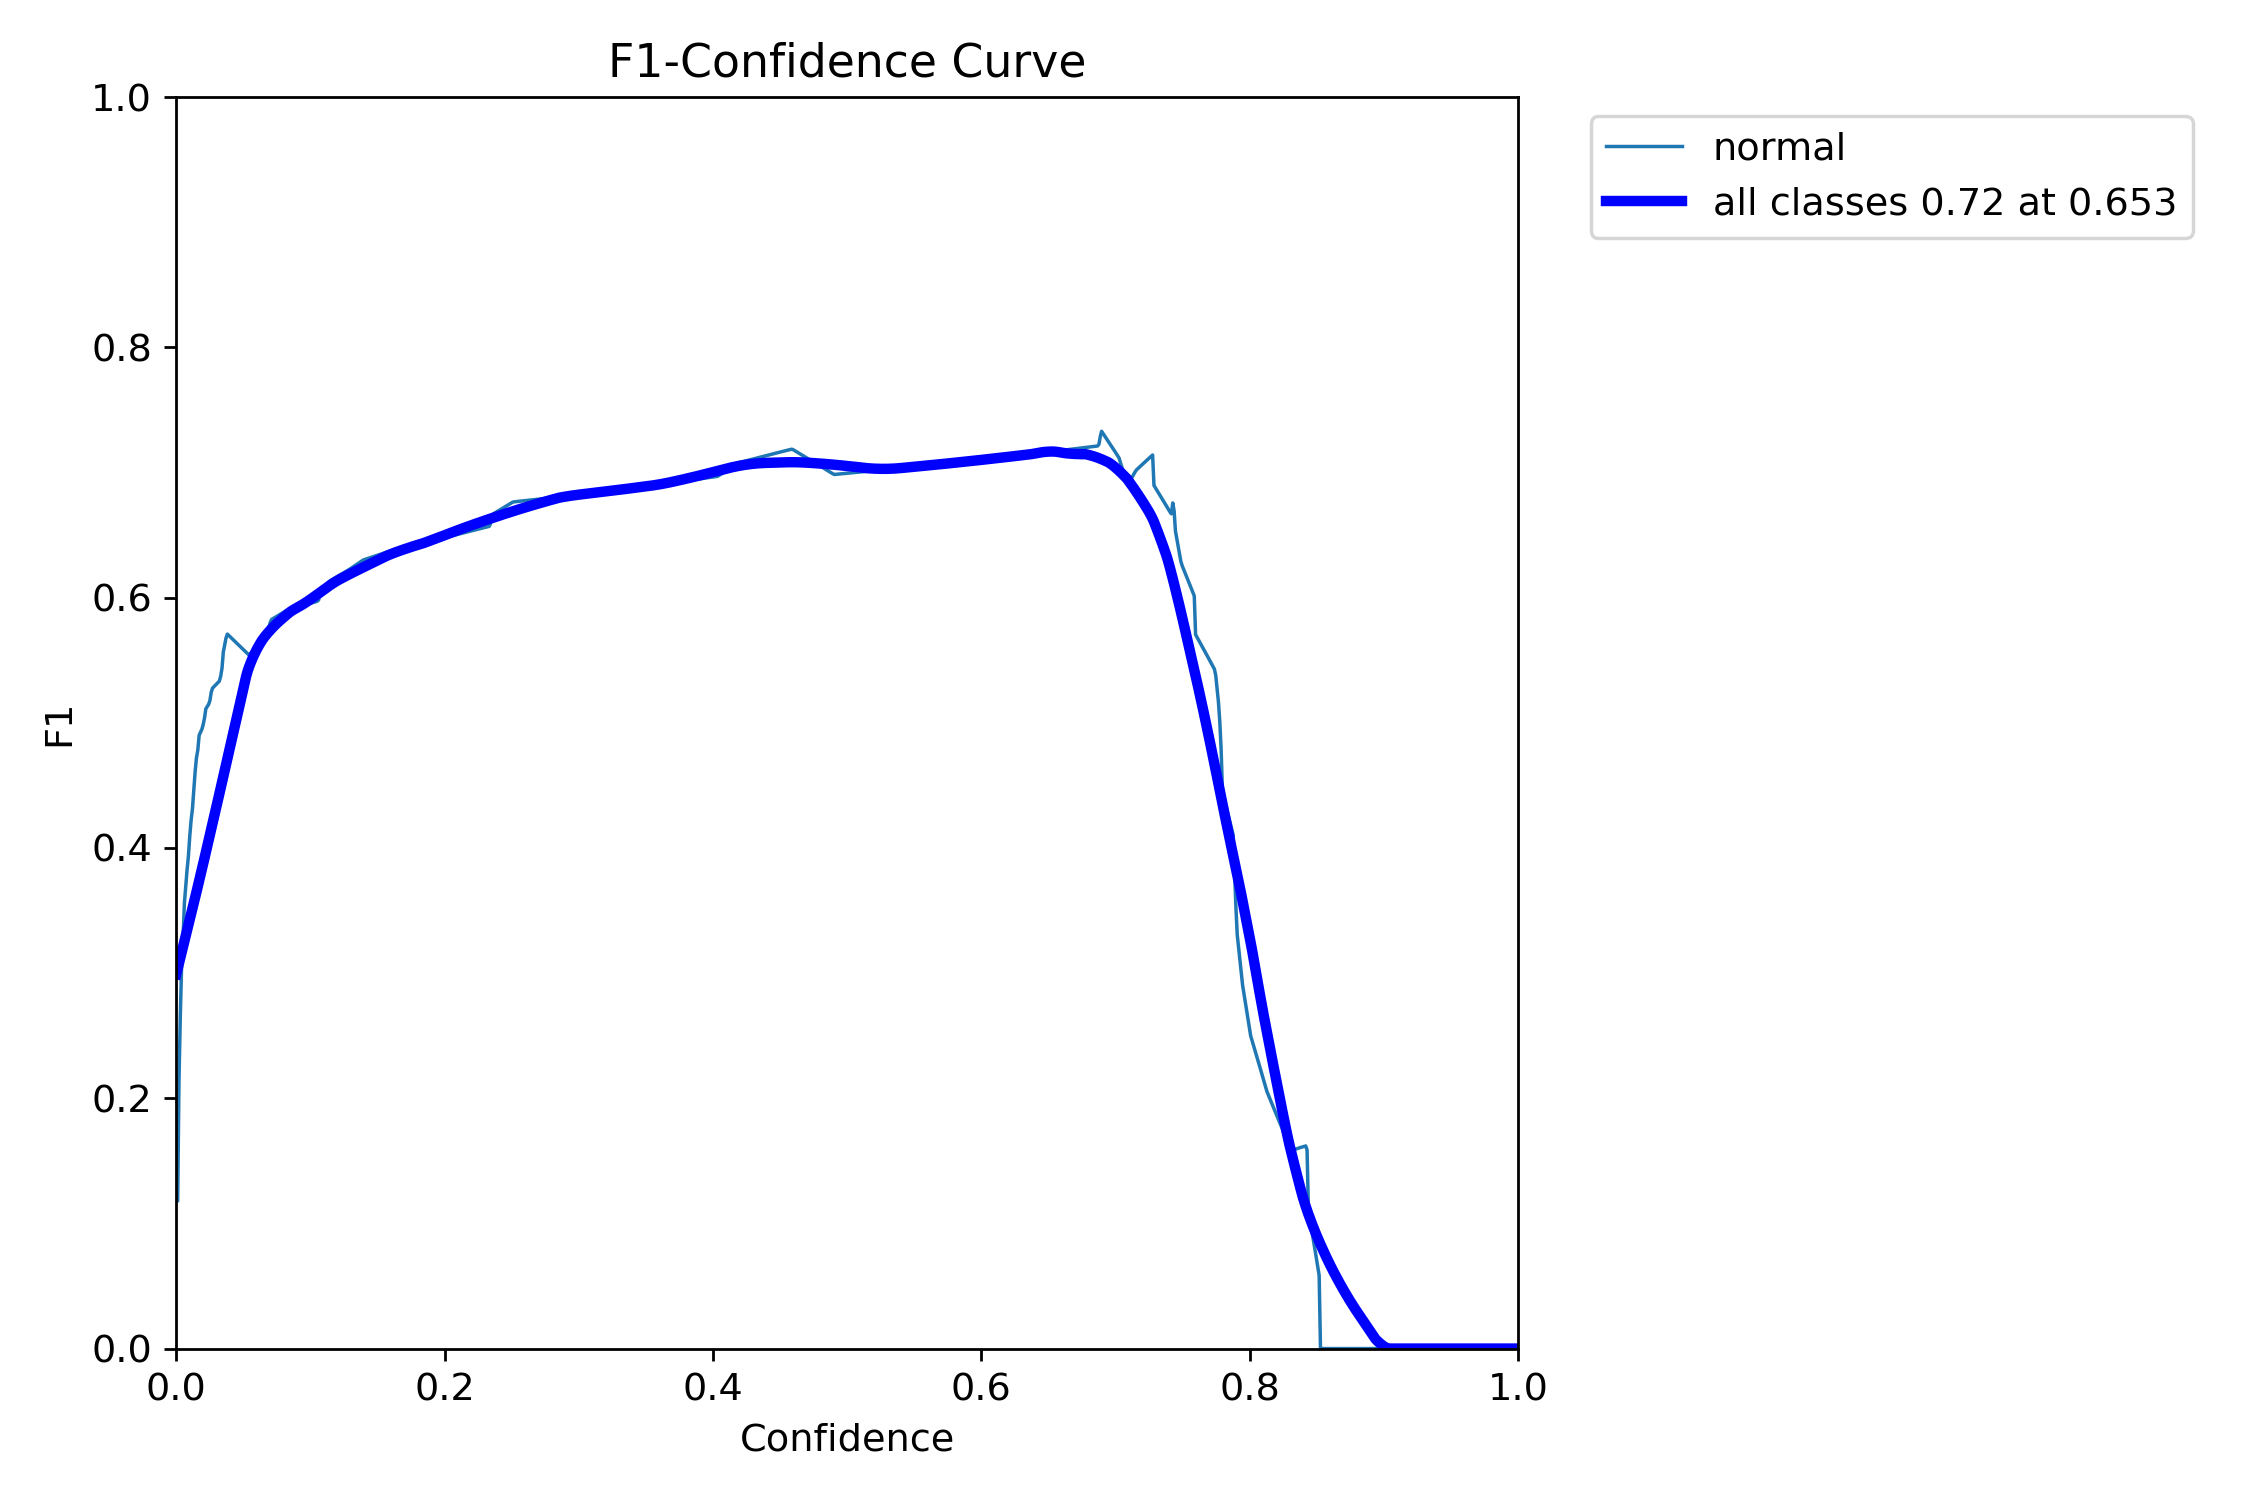

In [41]:
# Display the image from the saved path
Image(filename='/kaggle/working/runs/detect/train2/F1_curve.png')

In [1]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for images, targets in train_data_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        total_train_loss += losses.item()

    train_losses.append(total_train_loss / len(train_data_loader))

    # Validation loss
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for images, targets in val_data_loader:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            val_loss = sum(loss for loss in loss_dict.values())
            total_val_loss += val_loss.item()

    val_losses.append(total_val_loss / len(val_data_loader))

    print(f"Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}")


NameError: name 'num_epochs' is not defined